In [10]:
import numpy as np
import matplotlib.pyplot as plt

In [28]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from IPython.core.pylabtools import figsize
import numpy as np
import matplotlib.pyplot as plt

In [34]:
#파이썬예제 4.1 sympy를 이용한 연곡사각 신호의 푸리에 변환
#(a) sympy-CTFT: 중앙에 위치한 사각펄스 신호
from sympy import *
t, f = symbols('t f', real = True)
Tw = symbols('Tw', real = True, positive = True)
x = Heaviside(t+Tw/2) - Heaviside(t-Tw/2)
X = fourier_transform(x, t, f)
X

sin(pi*Tw*f)/(pi*f)

In [36]:
#(b) sympy-CTFT:지수신호
t, f = symbols('t f', real = True)
a = symbols('a', real = True, positive = True)
x = exp(-a*t)*Heaviside(t)
X = fourier_transform(x, t, f)
X

1/(a + 2*I*pi*f)

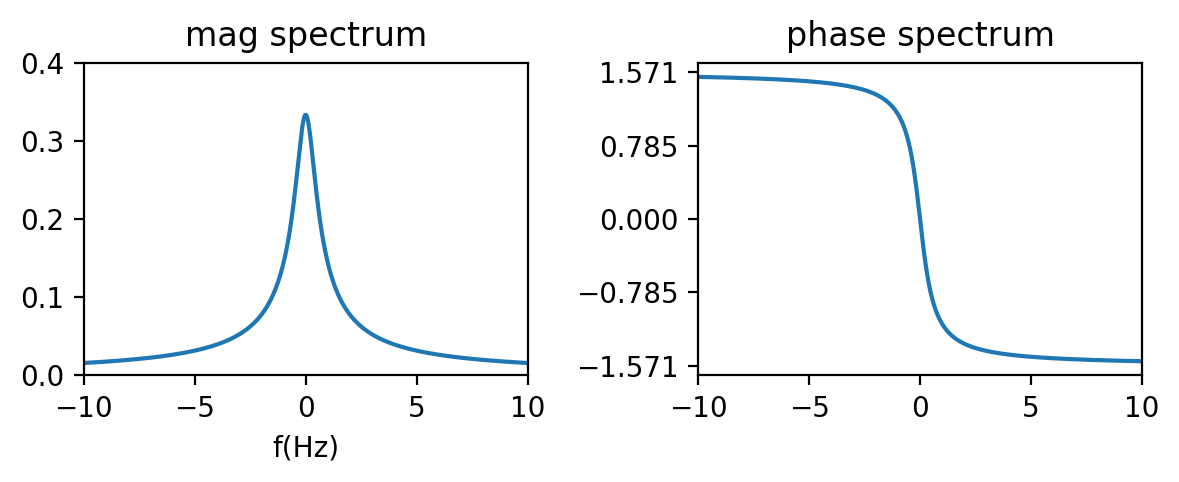

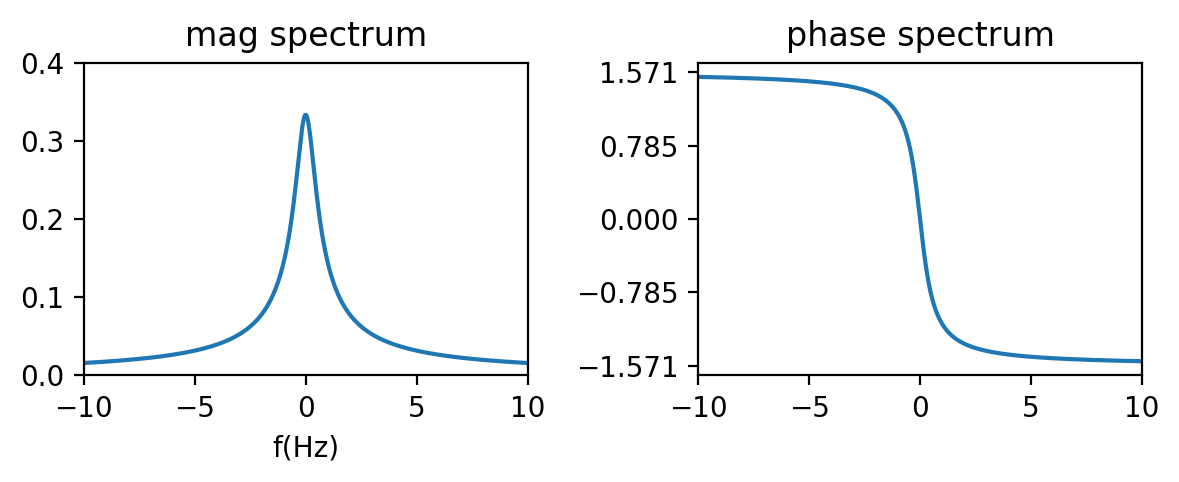

In [44]:
# (c) sympy 신호를 numpy 값으로 변환 후 플롯
lam_Xf = lambdify(f, X.subs(a, 3))
f_vals = np.linspace(-10, 10, 1001)
Xf = lam_Xf(f_vals)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 2.5))

# Magnitude spectrum
ax1.plot(f_vals, np.abs(Xf))
ax1.set_xlim(-10, 10)
ax1.set_ylim(0, 0.4)
ax1.set_xlabel('f(Hz)')
ax1.set_title('mag spectrum')

# Phase spectrum
ax2.plot(f_vals, np.angle(Xf))
ax2.set_xlim(-10, 10)
ax2.set_yticks([-np.pi/2, -np.pi/4, 0, np.pi/4, np.pi/2])
ax2.set_title('phase spectrum')

fig.tight_layout()
plt.show()

In [49]:
# 예제 4.2 푸리에변환의 수치계산과 근사계산
# (a) 수치계산을 이용한 CTFT 계산 함수
from scipy import integrate

def ctft_fixed_f(x, t, f):
    Xf = np.zeros(len(f), dtype=complex)

    # 주파수 f에 대해 CTFT 계산
    for k, f0 in enumerate(f):
        g = lambda t: x(t) * np.exp(-2j * np.pi * f0 * t)
        Xf[k] = integrate.simpson(y=g(t), x=t)

    return Xf

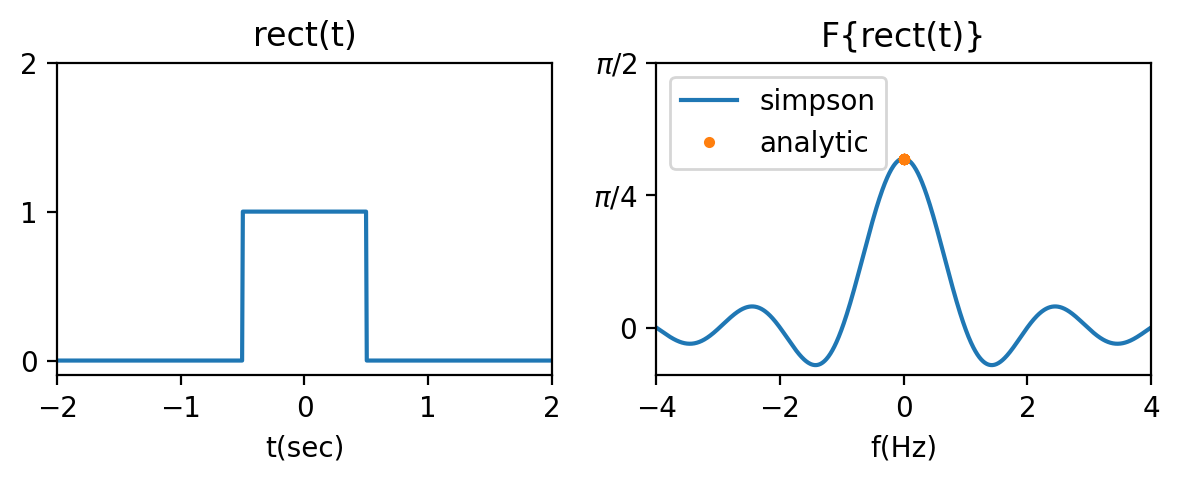

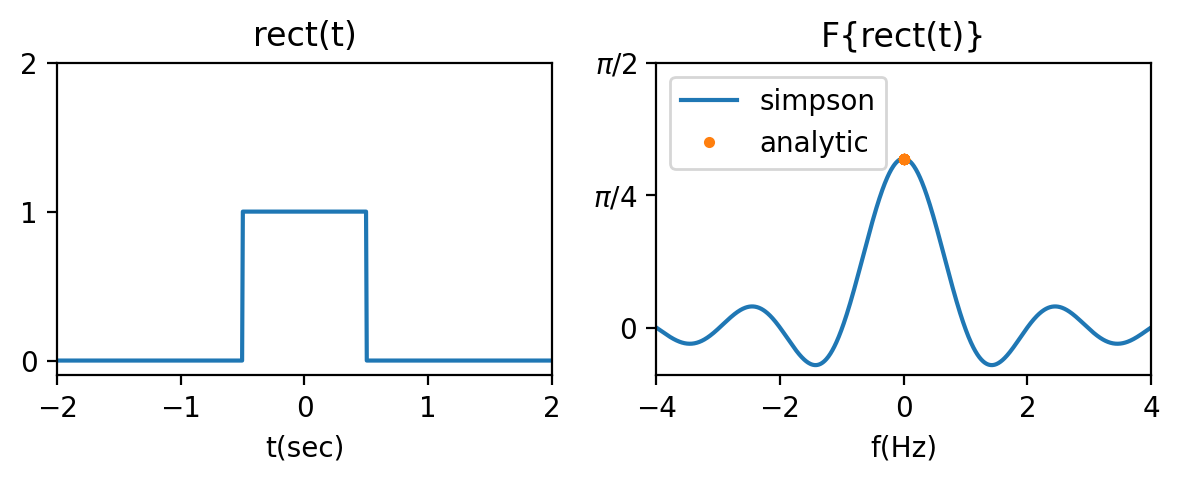

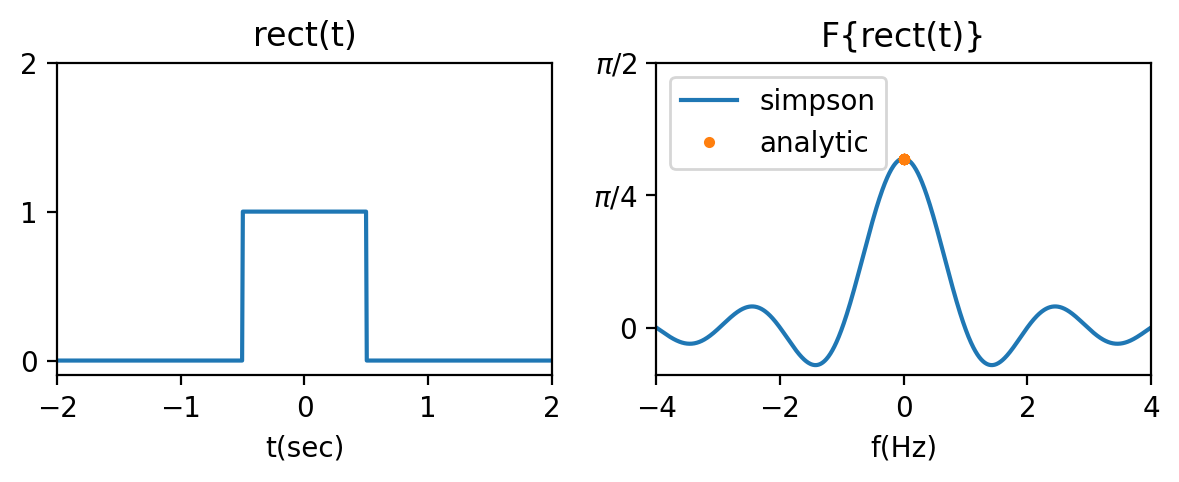

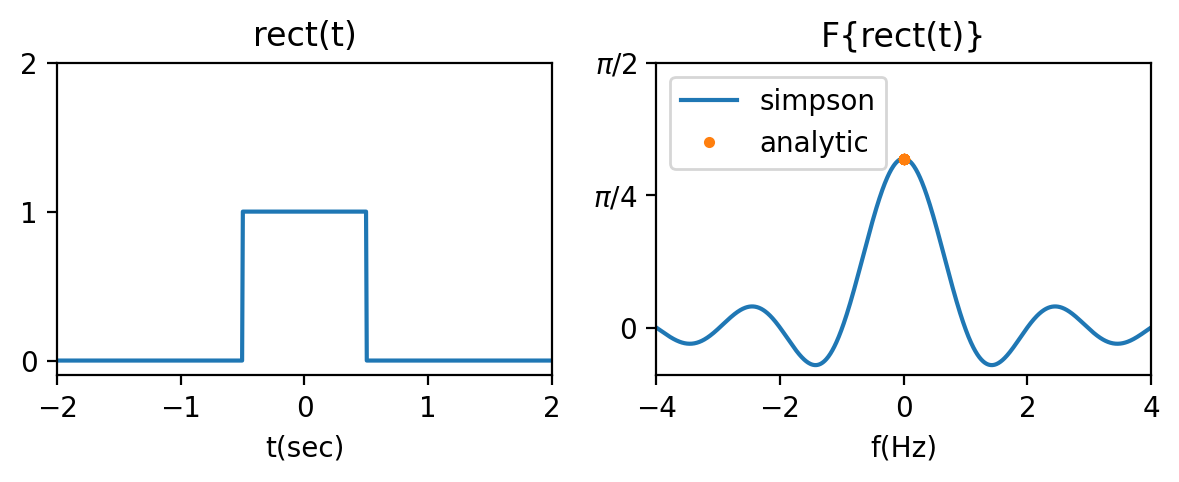

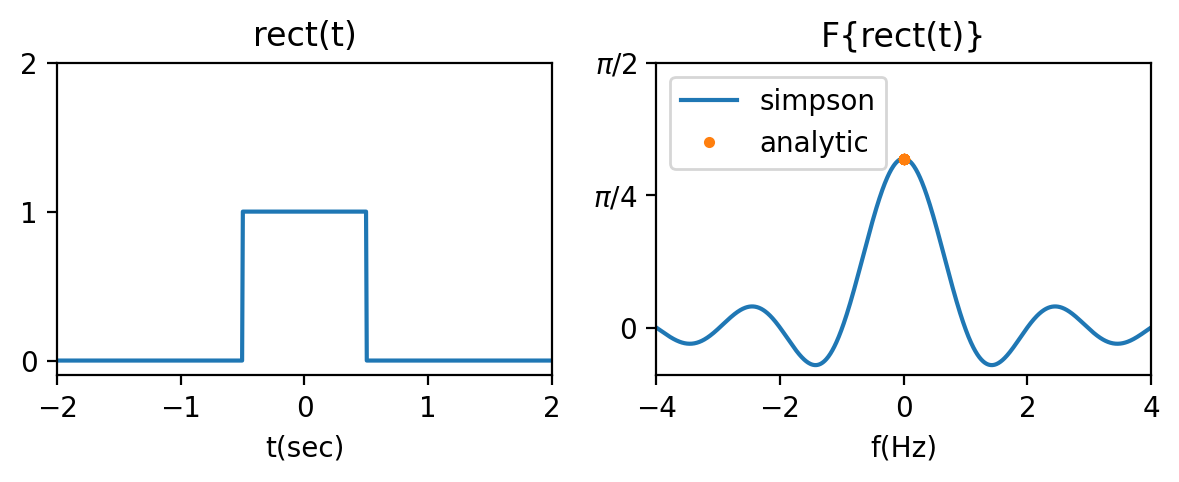

In [51]:
# (b) 사각파의 CTFT
def rect(t):
    return (abs(t) < 0.5).astype(float)

# 시간/주파수 축
t = np.linspace(-3, 3, 1001)
f = np.linspace(-4, 4, 1001)

# 수치적분 기반 CTFT 계산 (앞서 정의한 ctft_fixed_f 사용)
X = ctft_fixed_f(rect, t, f)

# 플롯
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 2.5))

ax1.plot(t, rect(t))
ax1.set_xlim(-2, 2)
ax1.set_ylim(-0.1, 1.5)
ax1.set_yticks([0, 1, 2])
ax1.set_xlabel('t(sec)')
ax1.set_title('rect(t)')

ax2.plot(f, X.real, label='simpson')
fs = np.linspace(-4, 4, 41) * 10**(-14)
ax2.plot(fs, np.sinc(fs), 'o', color='C1', ms=3, label='analytic')
ax2.set_xlim(-4, 4)
ax2.set_yticks([0, np.pi/4, np.pi/2])
ax2.set_yticklabels(['$0$', '$\\pi/4$', '$\\pi/2$'])
ax2.set_xlabel('f(Hz)')
ax2.set_title('F{rect(t)}')
ax2.legend(loc=2, fontsize=10)

fig.tight_layout()
plt.show()

In [82]:
# (c) DFT를 이용한 CTFT의 근사 계산
# 무한길이 신호 x(t)를 (t1, tN) 범위로 제한
# CTFT 결과를 DFT로 근사화

from scipy import signal
from numpy.fft import fft, fftshift

eps = 10e-10

def ctft_dft(xn, ts, t1=0.0):
    """
    xn : 샘플된 시간영역 신호 (길이 N)
    ts : 샘플링 간격 (=1/fs)
    t1 : 시간구간 시작점
    return: (f, X)  # 주파수축, 스펙트럼
    """
    N = len(xn)
    f = np.linspace(-1/(2*ts), 1/(2*ts), N, endpoint=False)       # [-fs/2, fs/2)
    X = fftshift(fft(xn)) * ts * np.exp(-2j*np.pi*f*t1)           # 시간시프트 보정
    # 거의 0인 허수/실수부는 수치오차 제거(옵션)
    if np.allclose(X.imag, 0, atol=1e-12): X = X.real
    return f, X

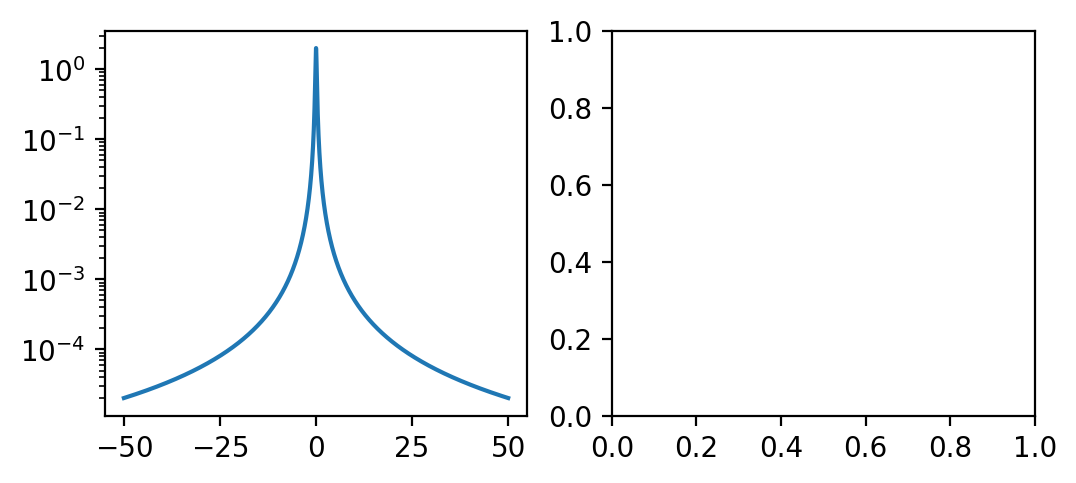

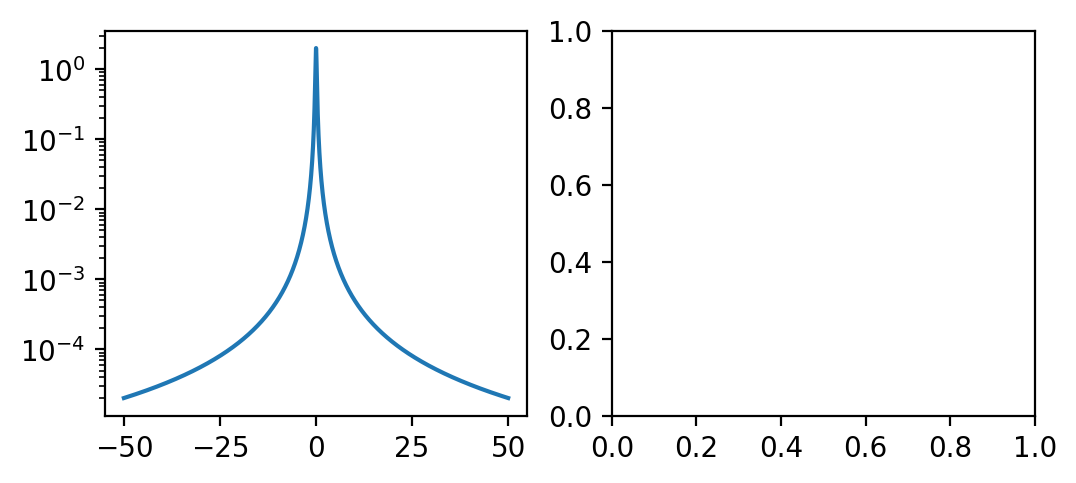

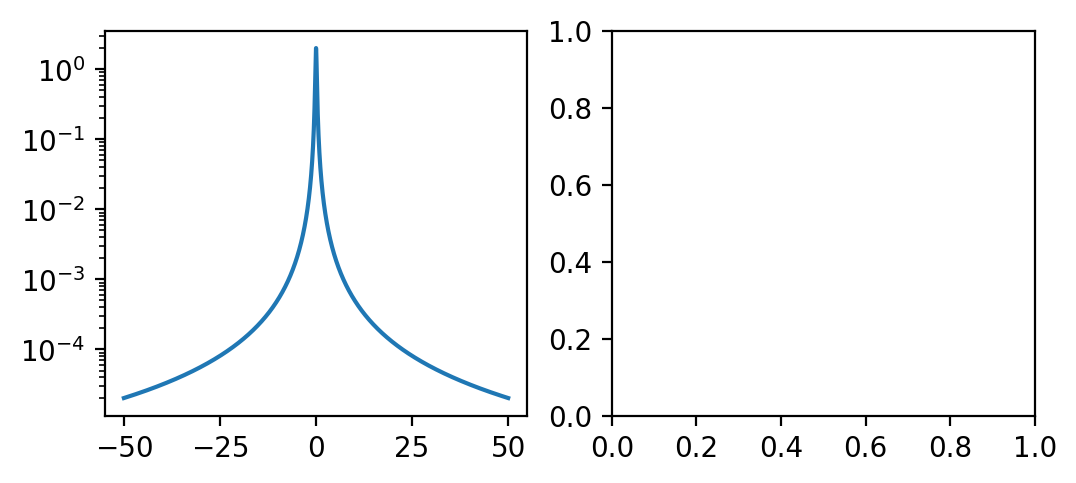

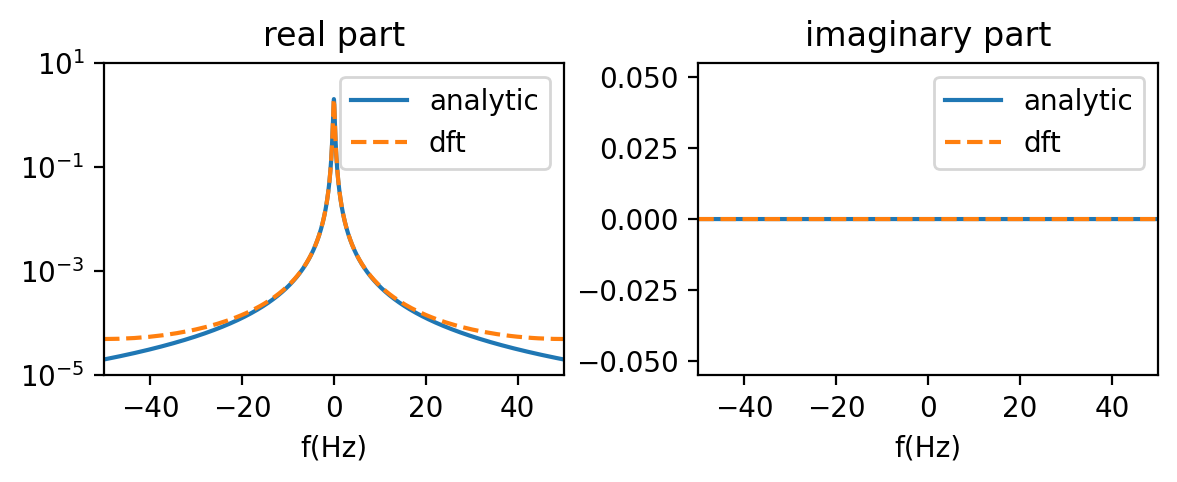

In [83]:
# (d) DFT/FFT를 이용한 사각파 신호의 CTFT 근사

x = lambda t: np.exp(-np.abs(t))
t1, t2 = -10, 10
fs = 100                     # 샘플링 주파수
ts = 1/fs

# 이론해: X(f) = 2 / (1 + (2πf)^2)
f_analytic = np.linspace(-fs/2, fs/2, 20001)
X_analytic = 2 / (1 + (2*np.pi*f_analytic)**2)

# DFT 근사
t_dft = np.arange(t1, t2, ts)
x_dft = x(t_dft)
f_dft, X_dft = ctft_dft(x_dft, ts, t1)

# --- Plot ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 2.5))

# real part (로그 스케일)
ax1.semilogy(f_analytic, X_analytic.real, label='analytic')
ax1.semilogy(f_dft,      np.real(X_dft),  '--', color='C1', ms=2, label='dft')
ax1.set_xlim(-fs/2, fs/2)
ax1.set_ylim(1e-5, 10)
ax1.set_xlabel('f(Hz)')
ax1.set_title('real part')
ax1.legend(fontsize=10, loc=1)

# imaginary part (거의 0)
ax2.plot(f_analytic, np.imag(X_analytic), label='analytic')
ax2.plot(f_dft,      np.imag(X_dft), '--', color='C1', ms=2, label='dft')
ax2.set_xlim(-fs/2, fs/2)
ax2.set_xlabel('f(Hz)')
ax2.set_title('imaginary part')
ax2.legend(fontsize=10, loc=1)

fig.tight_layout()
plt.show()

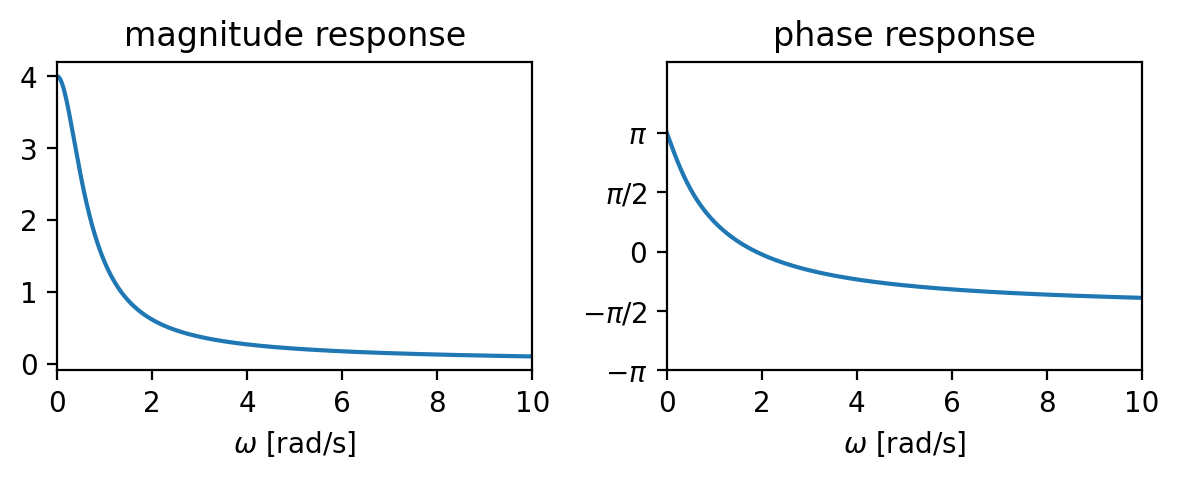

In [90]:
a = [1, 3/2, 1/2]
b = [1, -2]
wn = np.linspace(0, 10, 1001)
w, H = signal.freqs(b, a, worN=wn)

# 결과 플로팅
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 2.5))

ax1.plot(w, np.abs(H))
ax1.set_xlim(0, 10)
ax1.set_xlabel(r'$\omega$ [rad/s]')
ax1.set_title('magnitude response')

ax2.plot(w, np.angle(H))
ax2.set_xlim(0, 10)
ax2.set_ylim(-1.5, 5)
ax2.set_yticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi])
ax2.set_yticklabels([r'$-\pi$', r'$-\pi/2$', r'$0$', r'$\pi/2$', r'$\pi$'])
ax2.set_xlabel(r'$\omega$ [rad/s]')
ax2.set_title('phase response')

fig.tight_layout()
plt.show()

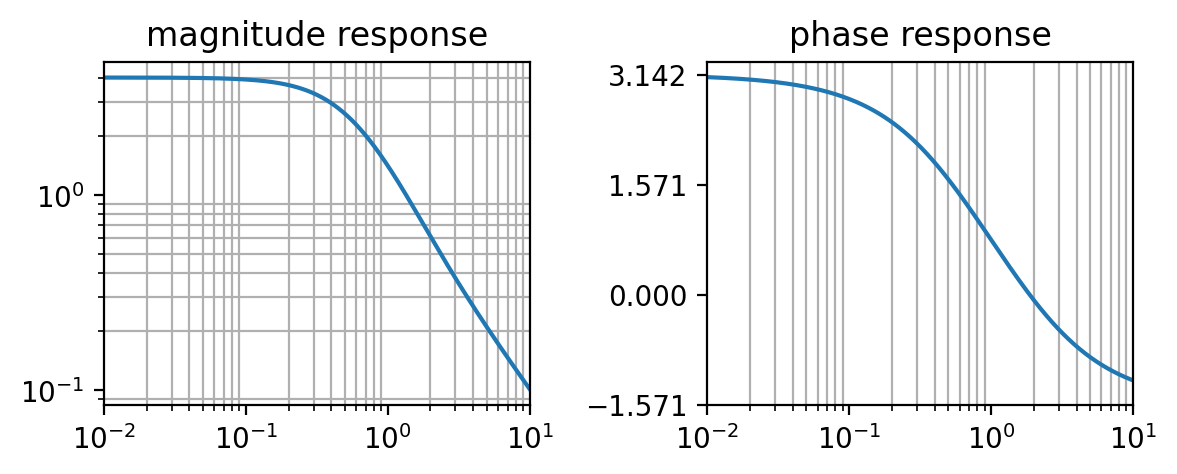

In [91]:
wn = np.logspace(-2, 1, 1001)
w, H = signal.freqs(b, a, worN=wn)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 2.5))

# Magnitude Response (로그 스케일)
ax1.loglog(w, np.abs(H))
ax1.set_xlim(0.01, 10)
ax1
ax1.set_title('magnitude response')
ax1.grid(True, which='minor')

# Phase Response
ax2.semilogx(w, np.angle(H))
ax2.set_xlim(0.01, 10)
ax2.set_yticks([ -np.pi/2, 0, np.pi/2, np.pi])
ax2.set_title('phase response')
ax2.grid(True, which='minor')

fig.tight_layout()
plt.show()

In [92]:
b = [1, 2]
a = [1, 4, 3]
r, p, k = signal.residue(b, a)
print('r:', r)
print('p:', p)
print('k:', k)

r: [0.5 0.5]
p: [-1. -3.]
k: []


In [95]:
b = [1, 2]
a = [1, 5, 7, 3]
r, p, k = signal.residue(b, a)
print('r:', r)
print('p:', p)
print('k:', k)

r: [ 0.25+0.j  0.5 +0.j -0.25+0.j]
p: [-1.+0.j -1.+0.j -3.+0.j]
k: []


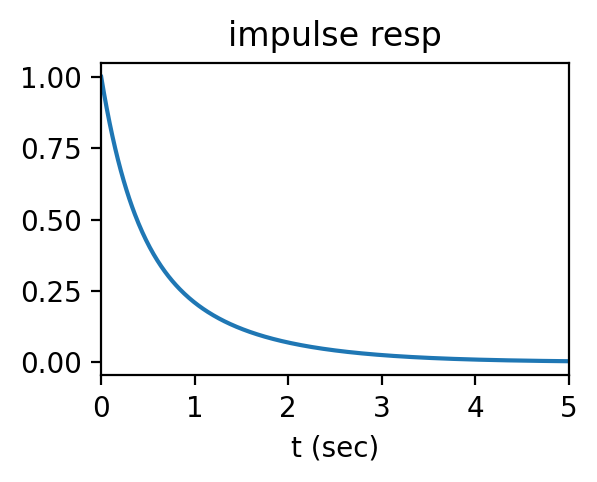

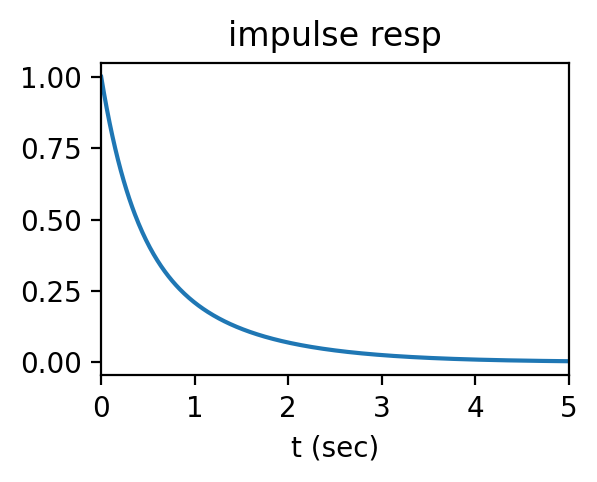

In [99]:
#부분분수 전개를 이용한 임펄스 응답 계산
b = [1, 2]
a = [1, 4, 3]
r, p, k = signal.residue(b, a)

t = np.linspace(0, 5, 501)   # 0~5초, 501포인트

# 임펄스 응답 계산 (residue 공식)
h = r[0]*np.exp(p[0]*t) + r[1]*np.exp(p[1]*t)

fig, ax = plt.subplots(figsize=(3, 2.5))
ax.plot(t, h)
ax.set_xlim(0, 5)
ax.set_xlabel('t (sec)')
ax.set_title('impulse resp')
fig.tight_layout()
plt.show()